
# MNIST CNN Training with PyTorch
This notebook demonstrates training a simple CNN on the MNIST dataset using PyTorch, along with key visualizations to understand the data and training process.


## Importing Libraries and Loading Data
This section includes importing necessary libraries, loading the MNIST dataset, defining a function to display images, and showing some random training images.

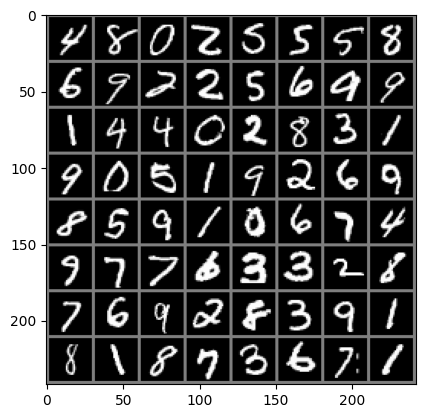

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split

# Transformation for the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load MNIST training dataset
full_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Splitting the full training dataset into train and validation sets
train_proportion = 0.8 # 80% of the full training dataset for training, remaining 20% for validation
train_size = int(train_proportion * len(full_trainset))
validation_size = len(full_trainset) - train_size
trainset, validateset = random_split(full_trainset, [train_size, validation_size])

# Creating data loaders for the train and validation sets
BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validateloader = DataLoader(validateset, batch_size=BATCH_SIZE, shuffle=True)

# Function to show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

## Defining the Convolutional Neural Network (CNN)
Here, we define the architecture of the CNN model that will be used for image classification.

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Training the CNN
In this section, we define the loss function and the optimizer, train the network on the MNIST dataset, and visualize the training loss curve to monitor the model's learning progression.

Using device: cuda:0
Epoch 1, Training Loss: 1.9656642552614212, Validation Loss: 0.6372151514317127
Epoch 2, Training Loss: 0.3441496449659268, Validation Loss: 0.22895366894675695
Epoch 3, Training Loss: 0.18973170903821787, Validation Loss: 0.15383837183818538
Epoch 4, Training Loss: 0.13936556197454533, Validation Loss: 0.1351201137765608
Epoch 5, Training Loss: 0.11459933467333515, Validation Loss: 0.11021997919801543
Epoch 6, Training Loss: 0.09875490060945352, Validation Loss: 0.10390940853741337
Epoch 7, Training Loss: 0.08758912725374103, Validation Loss: 0.09931129233990894
Epoch 8, Training Loss: 0.07933530770832052, Validation Loss: 0.08750182807078942
Epoch 9, Training Loss: 0.07216273084965845, Validation Loss: 0.07858875047593833
Epoch 10, Training Loss: 0.06752826136955992, Validation Loss: 0.07536942531116941
Epoch 11, Training Loss: 0.061697872264000274, Validation Loss: 0.07094947240647285
Epoch 12, Training Loss: 0.05941580131743103, Validation Loss: 0.0723554366788

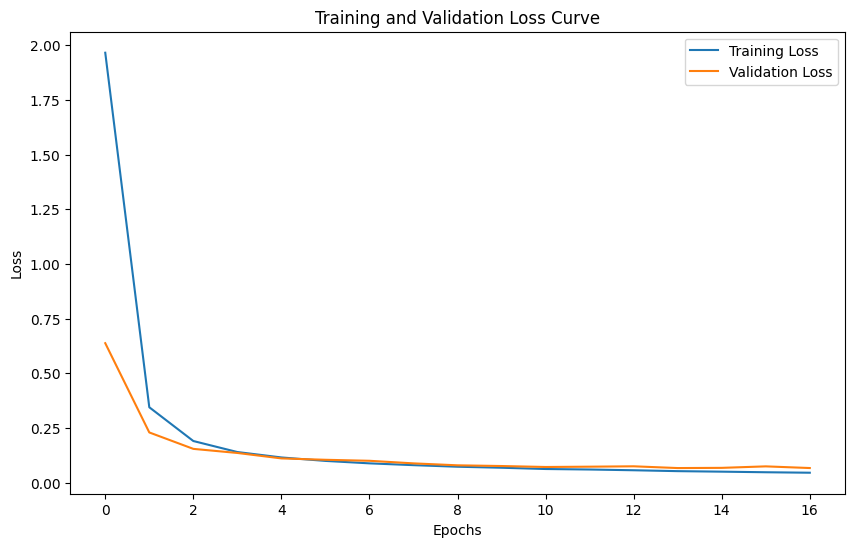

In [4]:
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the network
net = Net().to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Initialize lists to track loss and validation loss
train_loss_list = []
validation_loss_list = []

# Number of epochs to train the network
max_epochs = 50

# Early stopping parameters
min_epochs = 5
patience = 3
epochs_no_improve = 0
best_loss = np.inf

# Train the network
for epoch in range(max_epochs):  # loop over the dataset multiple times

    # Training Phase
    net.train()  # set the network to training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # send data to device
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss_list.append(running_loss / len(trainloader))

    # Validation Phase
    net.eval()  # set the network to evaluation mode
    validation_loss = 0.0
    with torch.no_grad():
        for data in validateloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

    validation_loss_list.append(validation_loss / len(validateloader))

    # Check if the validation loss improved
    if validation_loss < best_loss:
        best_loss = validation_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Early stopping check
    if epochs_no_improve == patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader)}, Validation Loss: {validation_loss / len(validateloader)}')

print('Finished Training')

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(validation_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

## Testing the Network
Finally, we test the trained CNN on test data, display some test images along with their actual and predicted labels.


In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Put the network on the device
net.to(device)

# Load the test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

# Set the network in evaluation mode
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:\n', conf_matrix)

Accuracy: 0.9822
Precision: 0.9823
Recall: 0.9822
F1 Score: 0.9822
Confusion Matrix:
 [[ 966    0    1    0    1    4    1    1    1    5]
 [   0 1127    2    1    0    0    1    2    2    0]
 [   0    0 1026    3    0    0    0    2    1    0]
 [   1    0    1  999    0    5    0    2    2    0]
 [   0    0    3    0  961    0    0    0    3   15]
 [   1    0    0   10    0  878    1    1    1    0]
 [   7    1    1    0    7   13  928    0    1    0]
 [   1    1    9    9    0    0    0  999    0    9]
 [   2    0    4    9    1    1    1    4  948    4]
 [   0    2    0    6    2    3    0    4    2  990]]
